In [1]:
import tensorflow
tensorflow.__version__

'2.3.0'

---

## 6.200 Understanding recurrent neural networks

The dense, fully connected layers and the convnet layers have no memory

These feedforward networks process each input in turn with no information transfer

A recurrent neural network (RNN) retains information of past inputs

The RNN has a feedback loop

The activation (layer output) $a(t - 1)$ at time $t - 1$ is fed back to the input where it joins the sequence term $x(t)$, at time $t$ 

DLWP: the previous activation is called a 'state' 

The previous activation is weighted and the network learns correlations with earlier inputs by adjusting these weights, in the usual manner

Here, we imagine that sequence terms $x(1), x(2), x(3), \ldots$ etc. occur at successive times, even if the sequence is not chronological

For example, successive words $x(1), x(2), x(3), \ldots$ 

of a single movie review

The state is reset before a new sequence (new movie review) is processed

Previously, in a feed forward networks, the entire sequence (review) was treated as a single input vector

##### Dense feedforward layer - recap

Layer input $x = [x_1, x_2, \ldots x_N]^T$

Layer output (activation) $a = [a_1, a_2, \ldots, a_M]^T$

There are $M$ output features (one per neuron/unit) and $N$ input features



The weight matrix is
 \begin{bmatrix}
  W_{11} & W_{12} & \ldots & W_{1N} \\
  W_{21} & W_{22} & \ldots & W_{2N} \\
  \ldots \\
  W_{M1} & W_{M2} & \ldots & W_{MN} \\
 \end{bmatrix}
 
and the bias is $b = [b_1, b_2, \ldots, b_M]$: there are $M \times N + M$ adjustable parameters

The layer activation is 

$
a = f(W \cdot x + b)
$

which means 

$
a_i = f\left(\sum_{j = 1}^{N} W_{ij}x_j + b_i\right).
$

##### The simple recurrent layer

There are two inputs: the current input, $x(t)$, and the previous activation, $a(t - 1)$ 

The activation from the RNN layer is 

$
a(t) = f(W \cdot x(t) + U \cdot a(t - 1) + b)
$


The previous activation, $a(t - 1)$, can have more or less effect on the current activation

The influence of the previous activation and input is controlled by the weights

The recursion

$
\begin{align*}
a(t) &= f(x(t), a(t-1)) \\
     &= f(x(t), f( x(t - 1),  a(t-2)) ) \\
     &= f( x(t),   f( x(t - 1),   f(x(t-2), a(t-3)) ) ) \\ 
     &= \ldots
\end{align*}
$

means that, in principle, all previous activations, 

even those reaching back into the distant past, can influence the present

The simple RNN layer in pseudocode is

In [ ]:
prev_output = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, prev_output) + b)
    prev_output = output_t

U is an $M \times M$ matrix - or, as a tensor, it has shape `(output_features, output_features)`

So, there are $M \times N + M + M \times M $ adjustable parameters

*Or*: each neuron has $N$ weights for the $N$ input features, $M$ weights for the previous output, and a bias: that's $(N + M + 1)$ parameters. But there are $M$ units, giving $(N + M + 1) \times M$ parameters

----

## 6.210 Simple RNN layer

The RNN pseudocode is implemented as a SimpleRNN layer

In [4]:
from tensorflow.keras.layers import SimpleRNN

`SimpleRNN` processes batches of sequences, like all other Keras layers

This means that it takes inputs of shape `(batch_size, timesteps, input_features)`

`SimpleRNN` (and all recurrent layers) can be run in two different modes: 

1. Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), 

2. Return only the last output for each input sequence (a 2D tensor of shape `(batch_size, output_features)`) 


These modes are controlled by the `return_sequences` constructor argument 

Let's take a look at an example:

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


The number of parameters in the `SimpleRNN` layer, from the above calculation is 

In [1]:
(32 + 32 + 1) * 32

2080

The following `SimpleRNN` layer returns the full sequence

In [4]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


Recurrent layers can be stacked in order to increase the representational power of the network

All intermediate layers must return full sequences:

In [5]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Let's try to classify IMDB movie reviews with an RNN

In [6]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Build and train a simple recurrent network - an `Embedding` layer, a `SimpleRNN` layer and a classifier:

In [7]:
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 19s 121ms/step - loss: 0.6067 - acc: 0.6651 - val_loss: 0.4249 - val_acc: 0.8318
Epoch 2/10
157/157 [==============================] - 18s 116ms/step - loss: 0.3680 - acc: 0.8483 - val_loss: 0.4968 - val_acc: 0.8030
Epoch 3/10
157/157 [==============================] - 18s 112ms/step - loss: 0.2814 - acc: 0.8882 - val_loss: 0.3794 - val_acc: 0.8456
Epoch 4/10
157/157 [==============================] - 17s 106ms/step - loss: 0.2175 - acc: 0.9176 - val_loss: 0.3391 - val_acc: 0.8702
Epoch 5/10
157/157 [==============================] - 16s 103ms/step - loss: 0.1757 - acc: 0.9359 - val_loss: 0.3886 - val_acc: 0.8450
Epoch 6/10
157/157 [==============================] - 16s 101ms/step - loss: 0.1351 - acc: 0.9541 - val_loss: 0.5445 - val_acc: 0.7674
Epoch 7/10
157/157 [==============================] - 16s 104ms/step - loss: 0.0984 - acc: 0.9679 - val_loss: 0.5324 - val_acc: 0.8398
Epoch 8/10
157/157 [==============================] - 1

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

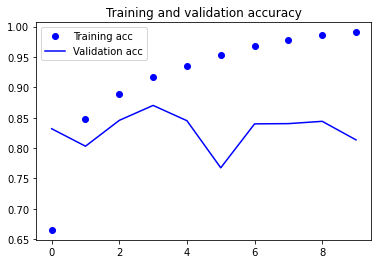

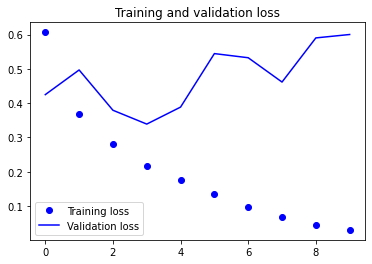

In [8]:
plt.show()

Best validation accuracy close to 87%

The three layer feed forward network of Topic 3 achieved about 89% test accuracy

Let's compare model architecture:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(layers.Dense(16, activation = 'relu', input_shape = (10000,)))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary()

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_20 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
________________________

The RNN has twice the capacity of the baseline feedforward model (they both have three layers) but underperforms

- the RNN has access to less information (only the first 500 words) than the baseline model

- `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. 

Let's take a look at some more advanced layers

----

## 6.220 Understanding LSTM layers

The simple RNN suffers from the vanishing gradients affliction

Long term dependencies stretching back in time are almost impossible to learn - the backpropagated signal progressively weakens

LSTM's have a conveyor - a mechanism that carries information forward in time. The conveyor sidesteps the vanishing gradients problem

But the LSTM is quite a complicated beast. We start by revise three common activation functions:

In [12]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def relu(x):
    y = np.zeros(len(x))
    return np.maximum(0, x)

import matplotlib.pyplot as plt

x = np.arange(-10, 10, 0.01)

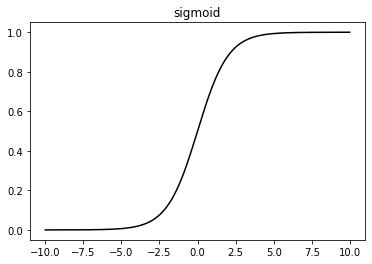

In [13]:
plt.plot(x, sigmoid(x), 'k')
plt.title('sigmoid')
plt.show()

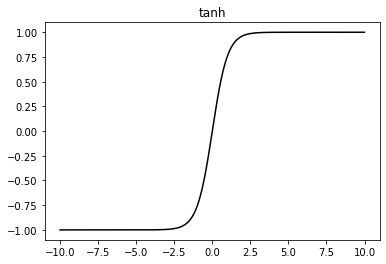

In [14]:
plt.plot(x, tanh(x), 'k')
plt.title('tanh')
plt.show()

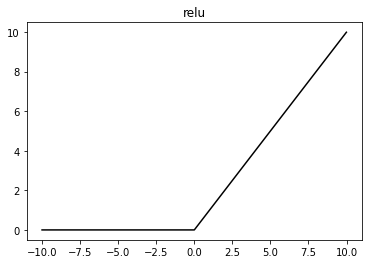

In [15]:
plt.plot(x, relu(x), 'k')
plt.title('relu')
plt.show()

##### Gates

Suppose we wish to turn an RNN off or on

Simple! Multiply by a binary switch: 

$\delta \times k(t)$ where $\delta$ takes values $0, 1$ and $k(t)$ is the activation of a simple RNN

The switch should have its own trainable parameters so that it can learn to be on/off for different inputs

Backpropagation requires differentiability

So the switch has to be a continuous function - it can't just instantaneously jump from 0 to 1

This is a gate - gates (unlike switches) can be half closed or quarter closed etc. - and degrees of closure might be advantageous

The sigmoid function takes values in $[0, 1]$ with a smooth changeover for arguments around $0$ 

Gated RNN: $ \boxed{\sigma(z) \times k(t)}$

But what is $z$?

We might want (because we are processing sequences) the state of the gate - on, off or in between - to depend on the current input and past activations:

$z = W \cdot x(t) + U \cdot a(t - 1) + b$

Our recurrently gated RNN is

$\boxed{\sigma(W \cdot x(t) + U \cdot a(t-1) + b) \times k(t)}$ 

##### LSTM pseudocode 

```
memory = gated_prev_memory + gated_simple_RNN
output_t = gated_tanh(memory)
```

````
memory = gated_prev_memory + gated_simple_RNN
output_t = gated_tanh(memory)
````

`output_t, prev_output`: current and previous LSTM layer outputs


````
memory = gated_prev_memory + gated_simple_RNN
output_t = gated_tanh(memory)
````

`memory`: aka 'carry' or 'state' - the conveyor, allowing free flow of information from the past (if gates are open) 

````
memory = gated_prev_memory + gated_simple_RNN
output_t = gated_tanh(memory)
````

`simple_RNN`: `tanh(dot(input_t, W) + dot(prev_output, U) + b)`

````
memory = gated_prev_memory + gated_simple_RNN
output_t = gated_tanh(memory)
````

`gated`: multiply by `sigmoid(dot(input_t, W) + dot(prev_output, U) + b)`

````
memory = gated_prev_memory + gated_simple_RNN
output_t = gated_tanh(memory)
````
`gated_tanh(memory)`: the memory is squashed to $[-1, 1]$ and gated

##### Parameters

All gates and simple RNN layers have their own parameters $(W, U, b)$

There are four $(W, U, b)$ units - 3 gates and the simple RNN, $k$

Each set of $(W, U, b)$ units has $M \times (M + N + 1)$ trainable parameters

Hence an LTSM layer has $4M(M + N + 1)$ trainable parameters.

##### The LSTM layer in detail

[A popular blog account](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) and [there's always Wikipedia](https://en.wikipedia.org/wiki/Long_short-term_memory)

##### Memory

The LTSM layer has a memory, called 'carry' by Chollet and, confusingly, 'state' by other authors. 

----

1. A forget gate:

$
f(t) = \sigma_g(W_f \cdot x(t) + U_f \cdot a(t - 1) + b_f)
$

$\sigma_g$ is a sigmoid, outputing in $[0, 1]$, a kind of smoothed 'gate'.

----

2. An input gate:

$
i(t) = \sigma_g(W_i \cdot x(t) + U_i \cdot a(t - 1) + b_i)
$

which we can also imagine as open or closed or in-between.

----

3. A simple RNN layer - to inject new information into the memory

$
k(t) = \sigma_h(W_k \cdot x(t) + U_k \cdot a(t - 1) + b_k)
$

where $\sigma_h$ is the $\tanh$ activation.

----

4. Putting all this together:

```
memory = gated_prev_memory + gated_simple_RNN
```

$
c(t) = f(t) * c(t - 1) + i(t) * k(t)
$



##### Output

----

1. An output gate

$
o(t) = \sigma_d(W_o \cdot x(t) + U_o \cdot a(t - 1) + b_o)
$

----
2. which multiplies, or gates, the memory

```
output_t = output_gate(t) * tanh-activation(memory)
```

$
a(t) = o(t) * \sigma_h(c(t))
$





$\sigma_h$ is a hyperbolic tangent (or, in a 'peephole' LSTM, the identity function $\sigma(x) = x$). 

Let's see how an LSTM is instantiated in `tensorflow.keras` and check the parameter count algebra:

In [3]:
import tensorflow.keras.models as models, tensorflow.keras.layers as layers

time_steps = 10
input_feats = 4
output_feats = 8

model = models.Sequential()
model.add(layers.LSTM(output_feats, input_shape=(time_steps, input_feats)))
print('Trainable params: ', 4 * output_feats * (output_feats + input_feats + 1), '\n')
model.summary()

Trainable params:  416 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 416       
Total params: 416
Trainable params: 416
Non-trainable params: 0
_________________________________________________________________


----

## 6.230 A concrete LSTM example

Set up a model with an LSTM layer

Train on IMDB data

The network will be similar to the earlier IMDB simple RNN model

We only specify the output dimensionality of the LSTM layer 

(there are many other arguments which we leave at the recommended default values)

In [9]:
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 38s 245ms/step - loss: 0.5273 - acc: 0.7477 - val_loss: 0.4331 - val_acc: 0.8048
Epoch 2/10
157/157 [==============================] - 34s 216ms/step - loss: 0.3066 - acc: 0.8819 - val_loss: 0.2901 - val_acc: 0.8818
Epoch 3/10
157/157 [==============================] - 40s 252ms/step - loss: 0.2457 - acc: 0.9074 - val_loss: 0.3075 - val_acc: 0.8682
Epoch 4/10
157/157 [==============================] - 37s 234ms/step - loss: 0.2031 - acc: 0.9240 - val_loss: 0.5283 - val_acc: 0.8436
Epoch 5/10
157/157 [==============================] - 39s 245ms/step - loss: 0.1808 - acc: 0.9328 - val_loss: 0.2874 - val_acc: 0.8824
Epoch 6/10
157/157 [==============================] - 35s 226ms/step - loss: 0.1599 - acc: 0.9431 - val_loss: 0.3899 - val_acc: 0.8616
Epoch 7/10
157/157 [==============================] - 34s 219ms/step - loss: 0.1503 - acc: 0.9469 - val_loss: 0.3154 - val_acc: 0.8878
Epoch 8/10
157/157 [==============================] - 3

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

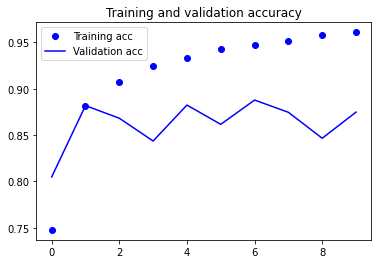

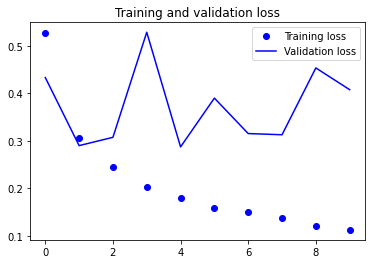

In [10]:
plt.show()

88% validation accuracy, improving slightly on the simple RNN result 

LSTM might perform better with hyper-parameter tuning and regularisation but the main issue is that the salient information in the reviews is not sequential - frequencies of positive and negative words are enough for good prediction  

----

## 6.240 Wrapping up

- Recurrent layers have a feedback loop enabling information to flow from the past
- LSTMs utilise a carry/memory to cure the vanishing gradient problem
- LSTMs are easily implemented: `model.add(LSTM(32))`

----

MIT Licence
 
Copyright (c) 2017-present François Chollet
 
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:
 
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
 
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.